In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [0]:

def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
	"""
	Return the magnitude of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	gradmag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(gradmag)/255
	gradmag = (gradmag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(gradmag)
	binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	"""
	Return the direction of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(absgraddir)
	binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

	# Return the binary image
	return binary_output


def hls_thresh(img, thresh=(100, 255)):
	"""
	Convert RGB to HLS and threshold to binary image using S channel
	"""
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
	gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=15, thresh_max=150)
	grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh_min=30, thresh_max=150)
	mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 100))
	dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
	hls_bin = hls_thresh(img, thresh=(170, 255))

	combined = np.zeros_like(mag_binary)
	combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | hls_bin == 1 ] = 1
	# combined[(gradx == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

	return combined


def wrap(img):
  img_size = (img.shape[1],img.shape[0])
  src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
  dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])
  M = cv2.getPerspectiveTransform(src,dst)

  warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
  return warped
src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])
Minv= cv2.getPerspectiveTransform(dst,src)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = wrap(combined_thresh(image))
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [0]:
def pipeline(img):    
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    output = drawLine(img, left_fit, right_fit)
    cv2.putText(output, 'Left Radius:', (10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))
    cv2.putText(output, str(leftCurvature), (220,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))
    cv2.putText(output, 'Right Radius:', (10,60),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))
    cv2.putText(output, str(rightCurvature), (220,60),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

In [0]:
img1 = plt.imread("hsl_original.jpg")
new_image = pipeline(img1)

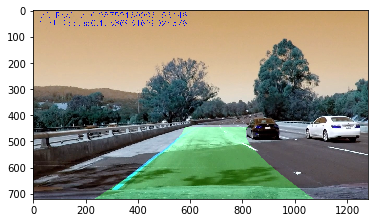

In [30]:
plt.imshow(new_image)